In [1]:
# let's use a simple neural network to recreate what we did in p1_bigram_lookup_table. We'll be trying
# to learn the same 27 x 27 probability lookup table from the last notebook using gradient descent on
# a single layer neural network.

# we'll need some stuff from the last notebook.
import matplotlib.pyplot as plt
import torch
torch.set_default_device("mps")

words = open('res/names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))  # tokens a-z

stoi = {s:i+1 for i,s in enumerate(chars)}  # map each token to unique id
stoi['.'] = 0  # add encoding for terminating token

itos = {i:s for s,i in stoi.items()}  # create the reverse mapping

In [2]:
# create the training set of bigrams
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        xs.append(idx1)
        ys.append(idx2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs)
print(ys)

tensor([ 0,  5, 13,  ..., 25, 26, 24], device='mps:0')
tensor([ 5, 13, 13,  ..., 26, 24,  0], device='mps:0')


In [3]:
import torch.nn.functional as F
x_enc = F.one_hot(xs, num_classes=27).float()
print(x_enc.shape)
print(x_enc)

torch.Size([228146, 27])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='mps:0')


torch.Size([10, 27])


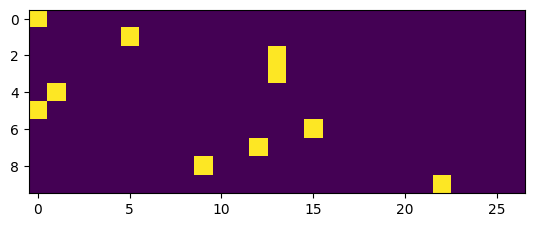

In [4]:
# visualize first 10 one-hot-encoded vectors
print(x_enc.cpu()[0:10].shape)
plt.imshow(x_enc.cpu()[0:10])

In [5]:
# let's create a "neuron"
W = torch.randn(27, 1)
a = x_enc[0:10] @ W  # (10, 27) @ (27, 1) -> (10, 1)

print(a)
print(a.shape)

tensor([[ 0.6894],
        [ 1.2910],
        [ 0.5924],
        [ 0.5924],
        [ 0.1887],
        [ 0.6894],
        [ 1.2367],
        [ 0.0932],
        [-0.7403],
        [-0.5791]], device='mps:0')
torch.Size([10, 1])


In [6]:
# let's create a "layer" of 27 neurons (each column in W is one neuron)
W = torch.randn(27, 27)
a = x_enc[0:10] @ W  # (10, 27) @ (27, 27) -> (10, 27)

print(a)
print(a.shape)

tensor([[ 0.0586,  0.6362,  2.1142,  2.3780,  0.9444,  0.8647, -0.8298,  1.9725,
          0.3329, -1.6866,  0.9905, -0.9820, -0.1480,  1.3446,  0.8581, -0.3066,
          0.2603,  2.7071, -1.8849, -1.5907,  2.4338, -0.9289,  0.4504, -0.0195,
         -0.7536, -0.5649, -1.0130],
        [-0.8139,  0.4150,  0.2339,  0.4533, -0.0938, -0.8165,  1.2347,  0.4995,
          2.0179,  0.0289, -0.4977, -0.2959,  0.4746, -0.3270,  1.9066,  2.6202,
          0.6514,  1.1816, -0.4126, -0.4150, -0.1506, -1.8668,  0.5241,  1.5906,
         -1.6751, -1.9510, -1.2522],
        [ 1.1713,  0.3099, -0.6206, -0.6400, -0.4006,  0.2353,  1.3758,  0.2120,
          0.7008, -1.2774, -0.7671,  1.7352, -0.4360, -0.6071,  1.7922, -0.1479,
         -0.0845, -0.6646,  2.1960,  0.0810, -1.0350,  0.4021,  1.1551,  2.0620,
         -0.7581, -1.3429,  1.6943],
        [ 1.1713,  0.3099, -0.6206, -0.6400, -0.4006,  0.2353,  1.3758,  0.2120,
          0.7008, -1.2774, -0.7671,  1.7352, -0.4360, -0.6071,  1.7922, -0.1479

In [7]:
# output of the 13th neuron when fed the 3rd input
#   - i.e. the dot product of the 3rd row of the input with the 13th column of the weights matrix
print((x_enc[0:10] @ W)[3, 13])
print((x_enc[3] * W[:, 13]).sum()) # equivalent

tensor(-0.6071, device='mps:0')
tensor(-0.6071, device='mps:0')


In [8]:
# ok so we have a basic neural network now.
#   - it takes batched input of shape `[batch_size, vocab_size]`.
#   - it has a hidden layer of `indims=vocab_size` and `outdims=vocab_size`.
#   - it outputs a tensor of shape `[batch_size, vocab_size]`.

# for each input, the output is a list of `vocab_size`-many random floating point numbers. we'd like to
# interpret the output as a probability distribution of the next token.
#   - in comes softmax to the rescue!
#   - by using softmax, we're basically saying that the network is outputting `log(counts)` (i.e. logits)
#     and we need exponentiate them to retrieve the `counts`.

# feed forward
logits = x_enc[0:10] @ W  # log-counts
# softmax
counts = logits.exp()  # counts (equivalent to N from p1_bigram_lookup_table)
probs = counts / counts.sum(dim=1, keepdim=True)  # probabilities for next character (equivalent to P from p1_bigram_lookup_table)

print("Logits:", logits)
print("Counts:", counts)
print("Probabilities:", probs)
print("Sum of probabilities over samples:", probs.sum(dim=1, keepdim=True))

Logits: tensor([[ 0.0586,  0.6362,  2.1142,  2.3780,  0.9444,  0.8647, -0.8298,  1.9725,
          0.3329, -1.6866,  0.9905, -0.9820, -0.1480,  1.3446,  0.8581, -0.3066,
          0.2603,  2.7071, -1.8849, -1.5907,  2.4338, -0.9289,  0.4504, -0.0195,
         -0.7536, -0.5649, -1.0130],
        [-0.8139,  0.4150,  0.2339,  0.4533, -0.0938, -0.8165,  1.2347,  0.4995,
          2.0179,  0.0289, -0.4977, -0.2959,  0.4746, -0.3270,  1.9066,  2.6202,
          0.6514,  1.1816, -0.4126, -0.4150, -0.1506, -1.8668,  0.5241,  1.5906,
         -1.6751, -1.9510, -1.2522],
        [ 1.1713,  0.3099, -0.6206, -0.6400, -0.4006,  0.2353,  1.3758,  0.2120,
          0.7008, -1.2774, -0.7671,  1.7352, -0.4360, -0.6071,  1.7922, -0.1479,
         -0.0845, -0.6646,  2.1960,  0.0810, -1.0350,  0.4021,  1.1551,  2.0620,
         -0.7581, -1.3429,  1.6943],
        [ 1.1713,  0.3099, -0.6206, -0.6400, -0.4006,  0.2353,  1.3758,  0.2120,
          0.7008, -1.2774, -0.7671,  1.7352, -0.4360, -0.6071,  1.7922,

In [9]:
# dig into how the network weights affect the loss function.
nlls = torch.zeros(10)
for i in range(10):
    # i-th bigram:
    x = xs[i].item()  # input character index
    y = ys[i].item()  # label character index
    print('--------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print( 'label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p. item())
    logp = torch. log (p)
    print('log likelihood:', logp.item())
    nll = -logp
    print( 'negative log likelihood:', nll.item())
    nlls[i] = nll
print('========')
print( 'average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0134, 0.0238, 0.1043, 0.1358, 0.0324, 0.0299, 0.0055, 0.0905, 0.0176,
        0.0023, 0.0339, 0.0047, 0.0109, 0.0483, 0.0297, 0.0093, 0.0163, 0.1887,
        0.0019, 0.0026, 0.1436, 0.0050, 0.0198, 0.0123, 0.0059, 0.0072, 0.0046],
       device='mps:0')
label (actual next character): 5
probability assigned by the net to the the correct character: 0.029895735904574394
log likelihood: -3.5100393295288086
negative log likelihood: 3.5100393295288086
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0076, 0.0258, 0.0215, 0.0268, 0.0155, 0.0075, 0.0586, 0.0281, 0.1282,
        0.0175, 0.0104, 0.0127, 0.0274, 0.0123, 0.1147, 0.2342, 0.0327, 0.0556,
        0.0113, 0.0113, 0.0147, 0.0026, 0.0288, 0.0836, 0.0032, 0.0024, 0.0049],
       device='mps:0')
label (actual next character): 13
probability ass

In [10]:
# we need to find weights that minimize the loss function.
#   - in comes gradient descent and pytorch's autograd to save the day.

# hyperparameters
eta = 50  # learning rate

# initialize model - single-layer, 27 neuron network
W = torch.randn(27, 27, requires_grad=True)  # track gradients on this layer

In [11]:
# single gradient descent pass on batch of size 10

# feed forward
logits = x_enc[0:10] @ W  # log-counts
counts = logits.exp()  # counts
probs = counts / counts.sum(dim=1, keepdim=True)  # probabilities for next character

# compute NLL loss
ys_pred = probs[torch.arange(0, 10), ys[0:10]]  # from each batch, select probability that we output the correct next token
loss = -ys_pred.log().mean()  # log, negate and mean the selected probabilities
print(loss)

# backward pass
W.grad = None  # zero the gradient
loss.backward()

# update model
W.data -= eta * W.grad

tensor(3.0901, device='mps:0', grad_fn=<NegBackward0>)


In [12]:
# full batch gradient descent (putting everything together)
for epoch in range(500):
    # feed forward
    logits = x_enc @ W  # log-counts
    counts = logits.exp()  # counts
    probs = counts / counts.sum(dim=1, keepdim=True)  # probabilities for next character

    # compute NLL loss
    ys_pred = probs[torch.arange(0, len(ys)), ys]  # from each batch, select probability that we output the correct next token
    loss = -ys_pred.log().mean()  # log, negate and mean the selected probabilities
    # loss += 0.01 * (W**2).mean()  # L2 regularization term (keep weights small by adding penalty)

    # backward pass
    W.grad = None  # zero the gradient
    loss.backward()

    # update model
    W.data -= eta * W.grad

    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 4.7517
Epoch 1: loss = 3.5674
Epoch 2: loss = 3.2590
Epoch 3: loss = 3.0933
Epoch 4: loss = 2.9757
Epoch 5: loss = 2.8898
Epoch 6: loss = 2.8271
Epoch 7: loss = 2.7800
Epoch 8: loss = 2.7430
Epoch 9: loss = 2.7131
Epoch 10: loss = 2.6885
Epoch 11: loss = 2.6678
Epoch 12: loss = 2.6503
Epoch 13: loss = 2.6353
Epoch 14: loss = 2.6223
Epoch 15: loss = 2.6110
Epoch 16: loss = 2.6010
Epoch 17: loss = 2.5922
Epoch 18: loss = 2.5843
Epoch 19: loss = 2.5772
Epoch 20: loss = 2.5708
Epoch 21: loss = 2.5649
Epoch 22: loss = 2.5596
Epoch 23: loss = 2.5547
Epoch 24: loss = 2.5502
Epoch 25: loss = 2.5461
Epoch 26: loss = 2.5423
Epoch 27: loss = 2.5387
Epoch 28: loss = 2.5354
Epoch 29: loss = 2.5324
Epoch 30: loss = 2.5295
Epoch 31: loss = 2.5269
Epoch 32: loss = 2.5244
Epoch 33: loss = 2.5220
Epoch 34: loss = 2.5198
Epoch 35: loss = 2.5177
Epoch 36: loss = 2.5158
Epoch 37: loss = 2.5139
Epoch 38: loss = 2.5121
Epoch 39: loss = 2.5105
Epoch 40: loss = 2.5089
Epoch 41: loss = 2.5074
Ep

In [13]:
# # minibatch gradient descent (putting everything together)
# bsz = 1000  # batch size
# for epoch in range(5):
#     for i in range(0, len(x_enc), bsz):
#         x_batch = x_enc[i:i+bsz]
#         y_batch = ys[i:i+bsz]
#
#         # feed forward
#         logits = x_batch @ W  # log-counts
#         counts = logits.exp()  # counts
#         probs = counts / counts.sum(dim=1, keepdim=True)  # probabilities for next character
#
#         # compute NLL loss
#         ys_pred = probs[torch.arange(0, len(y_batch)), y_batch]  # from each batch, select probability that we output the correct next token
#         loss = -ys_pred.log().mean()  # log, negate and mean the selected probabilities
#         loss += 0.01 * (W**2).mean()  # L2 regularization term (keep weights small by adding penalty)
#
#         # backward pass
#         W.grad = None  # zero the gradient
#         loss.backward()
#
#         # update model
#         W.data -= eta * W.grad
#
#     print(f"Epoch {epoch}: loss = {loss.item():.4f}")

In [14]:
# we expect to get roughly the same loss as in p1_bigram_lookup_table with our "manually tuned" bigram model (~2.45).
#   - it turns out that our original bigram model is trivially optimal.
#   - gradient descent has learned the same optimal strategy.
#       - W approximates N from the "manually tuned" model.
#   - this is the best the model can do with the data we've made available to it (bigrams), but the approach is flexible.
#       - if we feed it more information and add more neurons, it will find more complex relationships and perform better
#         than any "manually tuned" model we could come up with.

# To wrap things up, lets generate some samples from our neural net model.

for i in range(10):
    out = []
    ix = 0  # id of first token '.'
    while True:
        # fetch probability distribution from neural network
        x = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = x @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        p = counts / counts.sum(dim=1, keepdim=True)  # probabilities for next character
        # draw next token from multinomial distribution
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

eian.
ely.
fan.
rhmariaifaho.
a.
an.
shadaemalahei.
dr.
may.
asenbren.
